<a href="https://colab.research.google.com/github/pringleshu/2025-1_CV/blob/main/%EC%8B%A4%ED%97%98B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [130]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #
SEED = 42 # 삶과 우주, 그리고 모든 것에 대한 답은 42
np.random.seed(SEED)
torch.manual_seed(SEED) # PyTorch 랜덤
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED) # GPU 사용 시에도 시드

N_SAMPLES_MOONS = 1000 # make_moons 데이터셋 샘플 수
NOISE_MOONS = 0.25 # 데이터셋의 노이즈 수준
LEARNING_RATE = 0.01 # 학습률
WEIGHT_INIT_STD = 0.01 #  weight 초기값을 std=0.01 등 작게 설정하여 dead neuron 상황 유도
EPOCHS_MOONS = 300 # 총 에포크 수
BATCH_SIZE = 64 # 배치 크기
HIDDEN_SIZES_SHALLOW = [128, 64] # 은닉층 뉴런 수 구성 (첫 번째 은닉층 128개, 두 번째 64개)
INPUT_SIZE_MOONS = 2 # 입력 특성 수 (make_moons는 2차원)
NUM_CLASSES_MOONS = 2 # 출력 클래스 수 (이진 분류)


In [131]:
class MLP(nn.Module): # nn.Module을 상속받아 MLP 모델 정의
    def __init__(self, input_size, output_size, activation_name, init_std=0.01):
        super(MLP, self).__init__()
        self.activation_name = activation_name
        self.init_std = init_std

        self.layers = nn.ModuleList()
        self.activation_fns = nn.ModuleList()

        # 레이어 구조: Input -> 256 -> 128 -> Output
        # 첫 번째 은닉층
        self.layers.append(nn.Linear(input_size, 256))
        self.activation_fns.append(self._get_activation_fn(activation_name))

        # 두 번째 은닉층
        self.layers.append(nn.Linear(256, 128))
        self.activation_fns.append(self._get_activation_fn(activation_name))

        # 출력층
        self.layers.append(nn.Linear(128, output_size))

        self._initialize_weights()

    def _get_activation_fn(self, name):
        if name.lower() == 'relu':
            return nn.ReLU()
        elif name.lower() == 'leakyrelu':
            return nn.LeakyReLU(0.1)
        elif name.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {name}")

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=self.init_std)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, return_post_activations=False):
        post_activations = {}
        current_x = x

        # 첫 번째 은닉층 적용
        current_x = self.layers[0](current_x)
        current_x = self.activation_fns[0](current_x)
        if return_post_activations:
            post_activations[f'h1_{self.activation_name}'] = current_x.cpu().detach().clone()

        # 두 번째 은닉층 적용
        current_x = self.layers[1](current_x)
        current_x = self.activation_fns[1](current_x)
        if return_post_activations:
            post_activations[f'h2_{self.activation_name}'] = current_x.cpu().detach().clone()

        # 출력층 적용
        output = self.layers[2](current_x)

        if return_post_activations:
            return output, post_activations
        return output

In [132]:
def load_and_preprocess_data(dataset_name='make_moons', n_samples=N_SAMPLES_MOONS, noise=NOISE_MOONS, random_state=SEED):
    if dataset_name == 'make_moons': # 데이터셋 이름에 따라 데이터 생성
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    else:
        raise ValueError("Unsupported dataset name.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y) # 데이터를 학습용과 테스트용으로 분할

    scaler = StandardScaler() # 특성 스케일링을 위한 StandardScaler 객체 생성
    X_train_scaled = scaler.fit_transform(X_train) # 학습 데이터에 맞춰 스케일러 학습 및 변환
    X_test_scaled = scaler.transform(X_test) # 학습된 스케일러로 테스트 데이터 변환

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)# Numpy 배열을 PyTorch 텐서로 변환
    y_train_tensor = torch.tensor(y_train, dtype=torch.long) # CrossEntropyLoss는 target으로 long 타입을 기대
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)# TensorDataset과 DataLoader 생성
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # 학습용
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # 테스트용
    return train_loader, test_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler


In [133]:
def train_evaluate_model(model, criterion, optimizer,
                         train_loader, test_loader,
                         num_epochs, device):  # 모델을 학습하고 평가
    history = {  # 학습 과정 기록용
        'train_loss': [], 'val_loss': [],
        'train_acc':  [], 'val_acc': []
    }

    epoch_activations_log = {          # 특정 에폭의 활성화 값 저장용 딕셔너리
        'early': None, 'mid': None, 'late': None
    }

    # ⬇ 레이어별 gradient L2-norm 히스토리 (Linear weight만 추적)
    layer_grad_history = {"h1": [], "h2": [], "output": []}

    for epoch in range(num_epochs):  # 설정된 에폭 수만큼 반복
        model.train()                # 모델을 학습 모드로 설정
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:  # 학습 데이터 로더에서 배치 단위로 데이터 가져오기
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 지정된 장치로 이동
            optimizer.zero_grad()           # 옵티마이저의 기울기 초기화
            outputs = model(inputs)         # 모델 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()                 # 역전파를 통해 기울기 계산
            optimizer.step()                # 계산된 기울기로 모델 가중치 업데이트

            running_train_loss += loss.item() * inputs.size(0)  # 배치 손실 누적
            _, predicted = torch.max(outputs.data, 1)           # 예측 클래스
            total_train   += labels.size(0)                     # 총 샘플 수 누적
            correct_train += (predicted == labels).sum().item()  # 맞춘 샘플 수 누적
        with torch.no_grad():

            grad_bucket = {}

            for name, param in model.named_parameters():
                if "weight" not in name:          # bias 제외
                    continue
                if name.startswith("layers.0"):   layer_key = "h1"      # 첫 은닉층
                elif name.startswith("layers.1"): layer_key = "h2"      # 두 번째 은닉층
                elif name.startswith("layers.2"): layer_key = "output"  # 출력층
                else:                             layer_key = name.split('.')[0]
                norm_val = param.grad.norm().item() if param.grad is not None else 0.0
                grad_bucket.setdefault(layer_key, []).append(norm_val)

            for layer_key, norms in grad_bucket.items():
                mean_norm = float(np.mean(norms))
                layer_grad_history[layer_key].append(mean_norm)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)  # 에폭 평균 학습 손실
        epoch_train_acc  = correct_train / total_train                     # 에폭 학습 정확도
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        current_epoch_activations = {}  # 현재 에폭의 검증 데이터 활성화 값 (첫 배치 기준)

        with torch.no_grad():  # 평가 시에는 기울기 계산 비활성화
            for i, (inputs, labels) in enumerate(test_loader):  # 검증 데이터 로더
                inputs, labels = inputs.to(device), labels.to(device)
                if i == 0:  # 첫 번째 검증 배치에 대해서만 활성화 값 로깅 (일관성 유지)
                    outputs, post_acts = model(inputs, return_post_activations=True)
                    current_epoch_activations = post_acts  # 활성화 값 저장
                else:
                    outputs = model(inputs)  # 나머지 배치는 일반 순전파

                loss = criterion(outputs, labels)  # 검증 손실 계산
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val   += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader.dataset)  # 에폭 평균 검증 손실
        epoch_val_acc  = correct_val / total_val                      # 에폭 검증 정확도
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # 특정 에폭(초기, 중기, 후기)의 활성화 값 저장
        if epoch == 0:
            epoch_activations_log['early'] = current_epoch_activations
        if epoch == num_epochs // 2:  # 중간 에폭
            epoch_activations_log['mid'] = current_epoch_activations
        if epoch == num_epochs - 1:   # 마지막 에폭
            epoch_activations_log['late'] = current_epoch_activations

        # 학습 진행 상황 출력 (일정 간격 또는 마지막 에폭)
        if (epoch + 1) % (num_epochs // 10) == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
                  f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return history, epoch_activations_log, layer_grad_history


In [134]:
def plot_loss_accuracy(history, title_prefix=""): # 손실 및 정확도 곡선 시각화 함수
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 첫 번째 서브플롯 (손실 곡선)
    plt.plot(epochs_range, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Training and Validation Loss', fontsize=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.subplot(1, 2, 2) # 두 번째 서브플롯 (정확도 곡선)
    plt.plot(epochs_range, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title(f'{title_prefix} Training and Validation Accuracy', fontsize=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.tight_layout() # 서브플롯 간 간격 자동 조절
    plt.show() # 그래프 표시


In [135]:
def plot_decision_boundary(model, X_tensor_scaled, y_tensor, title_prefix="", device=DEVICE): # 결정 경계 시각화 함수
    model.eval() # 모델을 평가 모드로 설정
    X_numpy = X_tensor_scaled.cpu().numpy() # 시각화를 위해 텐서를 Numpy 배열로 변환
    y_numpy = y_tensor.cpu().numpy()

    # 시각화할 영역에 대한 그리드 생성
    x_min, x_max = X_numpy[:, 0].min() - 0.5, X_numpy[:, 0].max() + 0.5
    y_min, y_max = X_numpy[:, 1].min() - 0.5, X_numpy[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    grid_points = np.c_[xx.ravel(), yy.ravel()] # 그리드 포인트를 모델 입력 형태로 변환
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device) # 텐서로 변환 후 장치로 이동

    with torch.no_grad(): # 기울기 계산 비활성화
        Z = model(grid_tensor) # 그리드 포인트에 대한 모델 예측
        _, Z = torch.max(Z, 1) # 가장 확률 높은 클래스 선택
        Z = Z.cpu().numpy().reshape(xx.shape) # 결과를 그리드 형태로 변환

    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu) # 결정 경계 등고선 플롯
    plt.scatter(X_numpy[:, 0], X_numpy[:, 1], c=y_numpy, s=25, edgecolor='k', cmap=plt.cm.RdYlBu) # 실제 데이터 포인트
    plt.title(f'{title_prefix} Decision Boundary', fontsize=15)
    plt.xlabel('Feature 1 (scaled)', fontsize=12)
    plt.ylabel('Feature 2 (scaled)', fontsize=12)
    plt.show()

In [136]:
def plot_activation_distributions(epoch_activations_log, activation_name_str_main): # 활성화 값 분포 시각화 함수
    stages = ['early', 'mid', 'late'] # 분석할 학습 단계

    layer_keys = list(epoch_activations_log['early'].keys()) # 로그된 레이어 이름들 가져오기

    num_activation_layers = len(layer_keys) # 시각화할 활성화 레이어 수

    # 학습 단계별, 레이어별 활성화 값 분포를 서브플롯으로 그림
    fig, axes = plt.subplots(len(stages), num_activation_layers,
                             figsize=(6 * num_activation_layers, 5 * len(stages)),
                             squeeze=False) # squeeze=False로 axes를 항상 2D 배열로 받음
    fig.suptitle(f'{activation_name_str_main} - Activation Value Distributions', fontsize=18, y=1.03) # 전체 그림 제목

    for i, stage in enumerate(stages): # 각 학습 단계 (early, mid, late)에 대해 반복
        activations_at_stage = epoch_activations_log[stage] # 해당 단계의 활성화 값 딕셔너리
        if activations_at_stage is None: # 해당 단계 로그가 없으면 스킵
            print(f"Activation function '{activation_name_str_main}': No activation log for '{stage}' stage.")
            for j_ax in range(num_activation_layers): # 빈 서브플롯 처리
                 axes[i, j_ax].text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=10)
                 axes[i, j_ax].set_xticks([])
                 axes[i, j_ax].set_yticks([])
                 if i == 0: axes[i,j_ax].set_title(f"Layer {j_ax+1}\n(No data)", fontsize=12)
                 if j_ax == 0: axes[i,j_ax].set_ylabel(f"{stage.capitalize()} Stage", fontsize=12)
            continue

        for j, layer_name in enumerate(layer_keys): # 각 활성화 레이어에 대해 반복
            ax = axes[i, j] # 현재 서브플롯
            if layer_name in activations_at_stage:
                data = activations_at_stage[layer_name].flatten().numpy() # 활성화 값을 1D Numpy 배열로 변환
                sns.histplot(data, ax=ax, bins=30, kde=False) # 히스토그램 그리기
                ax.set_xlabel('Activation Value', fontsize=10)
                if i == 0: # 첫 번째 행(early stage)에만 레이어 이름(h1, h2 등) 표시
                    ax.set_title(f"{layer_name.split('_')[0]}", fontsize=14)
                if j == 0: # 첫 번째 열에만 y축 레이블(단계 이름) 표시
                     ax.set_ylabel(f"{stage.capitalize()} Stage\nFrequency", fontsize=12)
                else:
                    ax.set_ylabel('')
                ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.97]) #여백 확보
    plt.show()

In [137]:
def calculate_dead_neuron_ratio(model, data_loader, device): # 죽은 뉴런 비율 계산 함수
    model.eval() # 평가 모드
    all_post_activations_collector = {} # 모든 배치의 활성화 값을 모을 딕셔너리

    with torch.no_grad(): # 기울기 계산 비활성화
        for inputs, _ in data_loader: # 전체 데이터 로더(학습 또는 검증) 사용
            inputs = inputs.to(device)
            _, post_acts_batch = model(inputs, return_post_activations=True) # 현재 배치의 활성화 값들
            for name, act_tensor_batch in post_acts_batch.items(): # 각 레이어의 활성화 값에 대해
                if name not in all_post_activations_collector:
                    all_post_activations_collector[name] = []
                all_post_activations_collector[name].append(act_tensor_batch.cpu()) # CPU로 옮겨 저장

    concatenated_activations = {} # 모든 배치의 활성화 값을 하나로 합친 딕셔너리
    for name, list_of_tensors in all_post_activations_collector.items():
        if list_of_tensors:
             concatenated_activations[name] = torch.cat(list_of_tensors, dim=0) # 샘플 차원(dim=0)으로 합치기

    dead_neuron_ratios = {} # 레이어별 죽은 뉴런 비율 저장
    for layer_name, activations_tensor in concatenated_activations.items():
        if 'relu' not in layer_name.lower(): # ReLU 계열 활성화 함수가 아니면 스킵
            continue

        if activations_tensor.ndim < 2: # (샘플 수, 뉴런 수) 형태가 아니면 스킵
            continue

        num_total_neurons = activations_tensor.shape[1] # 해당 레이어의 총 뉴런 수
        if num_total_neurons == 0: # 뉴런이 없으면 0.0
            dead_neuron_ratios[layer_name] = 0.0
            continue

        # 죽은 뉴런 정의: 모든 샘플에 대해 출력이 0 (또는 매우 작은 값)인 뉴런
        if 'leakyrelu' in layer_name.lower(): # LeakyReLU의 경우 (0에 매우 가까운지 확인)
            dead_neurons_count = torch.all(torch.abs(activations_tensor) < 1e-6, dim=0).sum().item()
        else: # ReLU의 경우 (0 이하인지 확인)
            dead_neurons_count = torch.all(activations_tensor <= 1e-6, dim=0).sum().item()

        dead_ratio = dead_neurons_count / num_total_neurons # 죽은 뉴런 비율 계산
        dead_neuron_ratios[layer_name] = dead_ratio

    return dead_neuron_ratios # 레이어별 죽은 뉴런 비율 반환

In [138]:
def plot_dead_neuron_heatmap(dead_neuron_ratios_all_activations, title_prefix="Experiment B"): # 죽은 뉴런 히트맵 시각화
    df_data_list = [] # 히트맵용 DataFrame을 만들기 위한 리스트
    for act_fn_name, layer_ratios_dict in dead_neuron_ratios_all_activations.items():
        if 'relu' not in act_fn_name.lower(): # ReLU 계열 활성화 함수만 대상
            continue
        for layer_name, ratio in layer_ratios_dict.items():
            clean_layer_name = layer_name.split('_')[0]
            df_data_list.append({
                'Activation Function': act_fn_name,
                'Hidden Layer': clean_layer_name,
                'Dead Neuron Ratio (%)': ratio * 100 # 백분율로 저장
            })

    if not df_data_list: # DataFrame 만들 데이터가 없으면 경고 후 종료
        print("No dead neuron data for ReLU or LeakyReLU, cannot generate heatmap.")
        return

    df_heatmap = pd.DataFrame(df_data_list) # 리스트를 DataFrame으로 변환

    try:
        heatmap_pivot = df_heatmap.pivot_table(index='Hidden Layer', # pivot_table을 사용하여 히트맵 데이터 형태로 재구성
                                               columns='Activation Function',
                                               values='Dead Neuron Ratio (%)',
                                               sort=True) # 은닉층 이름 순으로 정렬

        plt.figure(figsize=(10, max(4, len(heatmap_pivot.index) * 0.8))) # 크기 조절
        # seaborn heatmap 그리기 (값 표시, 색상맵, 선 등 설정)
        sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5, cbar_kws={'label': 'Dead Neuron Ratio (%)'})
        plt.title(f'{title_prefix}: Dead Neuron Ratio by Activation Function', fontsize=15)
        plt.ylabel('Hidden Layer', fontsize=12)
        plt.xlabel('Activation Function', fontsize=12)
        plt.xticks(rotation=0) # x축 레이블 회전 없음
        plt.yticks(rotation=0) # y축 레이블 회전 없음
        plt.tight_layout()
        plt.show()
    except Exception as e: # 히트맵 생성 중 오류 발생 시
        print(f"Error generating heatmap: {e}")
        print("DataFrame content:\n", df_heatmap)

In [139]:
def plot_combined_loss_accuracy(histories_dict, title="Combined Curves"):
    # 에폭 범위 (= 첫 history 길이 기준)
    n_epoch = len(next(iter(histories_dict.values()))['train_loss'])
    epochs  = range(1, n_epoch + 1)

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    for act_name, hist in histories_dict.items():
        plt.plot(epochs, hist['train_loss'],  linestyle='-',  label=f'{act_name}  (train)')
        plt.plot(epochs, hist['val_loss'],    linestyle='--', label=f'{act_name}  (val)')
    plt.title('Loss vs Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12);  plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=9);  plt.grid(True, linestyle='--', alpha=0.5)

    # Accuracy
    plt.subplot(1, 2, 2)
    for act_name, hist in histories_dict.items():
        plt.plot(epochs, hist['train_acc'], linestyle='-',  label=f'{act_name}  (train)')
        plt.plot(epochs, hist['val_acc'],   linestyle='--', label=f'{act_name}  (val)')
    plt.title('Accuracy vs Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12);  plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=9);  plt.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [140]:
def plot_sigmoid_vanishing_gradients(epoch_activations_log, threshold=0.01, title_prefix="Sigmoid"):

    stages = ['early', 'mid', 'late']
    layer_keys = list(epoch_activations_log['early'].keys())  # h1_sigmoid, h2_sigmoid
    n_layers = len(layer_keys)

    fig, axes = plt.subplots(len(stages), n_layers,
                             figsize=(6 * n_layers, 4 * len(stages)),
                             squeeze=False)
    fig.suptitle(f"{title_prefix} · Sigmoid-Derivative Distributions "
                 f"(grad = a·(1-a))", fontsize=17, y=1.03)

    vanishing_table = []

    for r, stage in enumerate(stages):
        acts_stage = epoch_activations_log[stage]
        if acts_stage is None:
            continue

        for c, layer_name in enumerate(layer_keys):
            a = acts_stage[layer_name].flatten()
            grad = a * (1 - a)
            ax = axes[r, c]
            sns.histplot(grad.numpy(), bins=40, ax=ax, kde=False, color='steelblue')
            ax.set_title(f"{stage.capitalize()}  ·  "
                         f"{layer_name.split('_')[0]}", fontsize=12)
            ax.set_xlabel("σ′(z)"); ax.set_ylabel("Count")
            ax.grid(True, ls='--', alpha=.5)

            # vanishing 비율 계산 및 저장
            vanish_ratio = (grad < threshold).float().mean().item() * 100
            vanishing_table.append((stage, layer_name, vanish_ratio))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    df_vanish = (pd.DataFrame(vanishing_table,
                              columns=["Stage", "Layer", f"Grad<{threshold} (%)"])
                   .pivot(index="Layer", columns="Stage",
                          values=f"Grad<{threshold} (%)")
                   .round(1))
    print("\n Vanishing-Gradient 비율 (%)")
    display(df_vanish)


In [141]:
def plot_layer_contribution_heatmap(layer_grad_hist, act_name, norm_type="row", log1p=True):
    import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

    df = pd.DataFrame(layer_grad_hist).T              # rows=layer
    df = df.replace({0: np.nan})                      # 모두 0 이면 NaN 처리 → 시각적으로 흰색
    if log1p:
        df = np.log1p(df)                             # log(1+g)

    if norm_type == "row":
        df = df.div(df.max(axis=1), axis=0)           # 0~1 로 정규화

    df.dropna(how="all", inplace=True)                # 값 전부 NaN 인 레이어 제거
    if df.empty:
        print(f"[WARN] {act_name}: gradient 기록이 없습니다.")
        return

    plt.figure(figsize=(12, 1 + 0.6*len(df)))
    sns.heatmap(df, cmap="YlGnBu", vmin=0, vmax=1,
                cbar_kws={'label':'Gradient Strength (norm, scaled)'})
    plt.title(f"{act_name} · Layer-wise Gradient Contribution", fontsize=14)
    plt.xlabel("Epoch"); plt.ylabel("Layer")
    plt.tight_layout(); plt.show()


In [142]:
def grad_vanishing_matrix(layer_grad_hist, threshold=1e-4):

    import pandas as pd, numpy as np
    df = pd.DataFrame(layer_grad_hist)          # (epoch, layer)
    df = df.T                                   # (layer, epoch)
    vanish_df = (df < threshold).astype(int)    # 1/0 표시
    return vanish_df

def plot_grad_vanishing_heatmap(vanish_df, act_name, threshold=1e-4):

    import seaborn as sns, matplotlib.pyplot as plt
    plt.figure(figsize=(12, 0.6 * len(vanish_df) + 2))
    sns.heatmap(vanish_df, cmap="Reds",
                cbar_kws={'label': f'Grad < {threshold} (1=yes)'},
                linewidths=.5)
    plt.title(f"{act_name} · Gradient Vanishing Map", fontsize=14)
    plt.xlabel("Epoch"); plt.ylabel("Layer")
    plt.tight_layout(); plt.show()


Epoch [30/300], Train Loss: 0.1414, Train Acc: 0.9463, Val Loss: 0.0729, Val Acc: 0.9850
Epoch [60/300], Train Loss: 0.1319, Train Acc: 0.9487, Val Loss: 0.0716, Val Acc: 0.9800
Epoch [90/300], Train Loss: 0.1309, Train Acc: 0.9437, Val Loss: 0.0710, Val Acc: 0.9800
Epoch [120/300], Train Loss: 0.1241, Train Acc: 0.9450, Val Loss: 0.0803, Val Acc: 0.9700
Epoch [150/300], Train Loss: 0.1201, Train Acc: 0.9475, Val Loss: 0.0614, Val Acc: 0.9800
Epoch [180/300], Train Loss: 0.1107, Train Acc: 0.9525, Val Loss: 0.0679, Val Acc: 0.9700
Epoch [210/300], Train Loss: 0.1135, Train Acc: 0.9463, Val Loss: 0.0643, Val Acc: 0.9800
Epoch [240/300], Train Loss: 0.1054, Train Acc: 0.9513, Val Loss: 0.0683, Val Acc: 0.9800
Epoch [270/300], Train Loss: 0.1104, Train Acc: 0.9513, Val Loss: 0.0862, Val Acc: 0.9650
Epoch [300/300], Train Loss: 0.0983, Train Acc: 0.9563, Val Loss: 0.0736, Val Acc: 0.9700


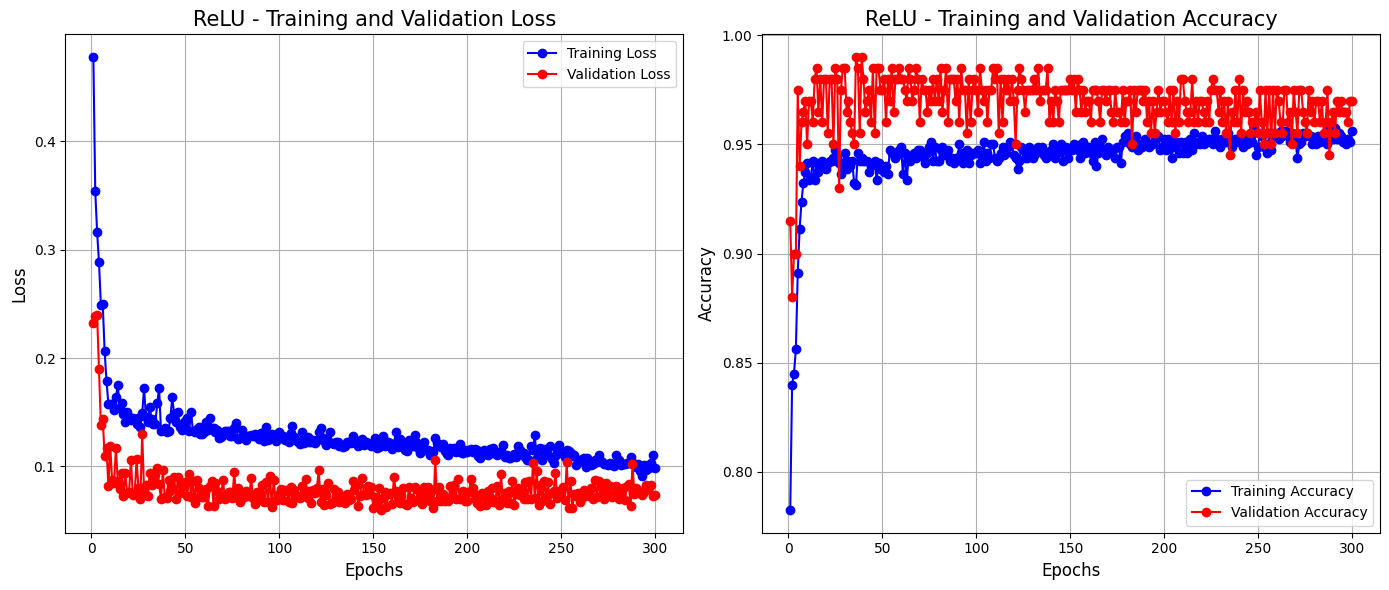

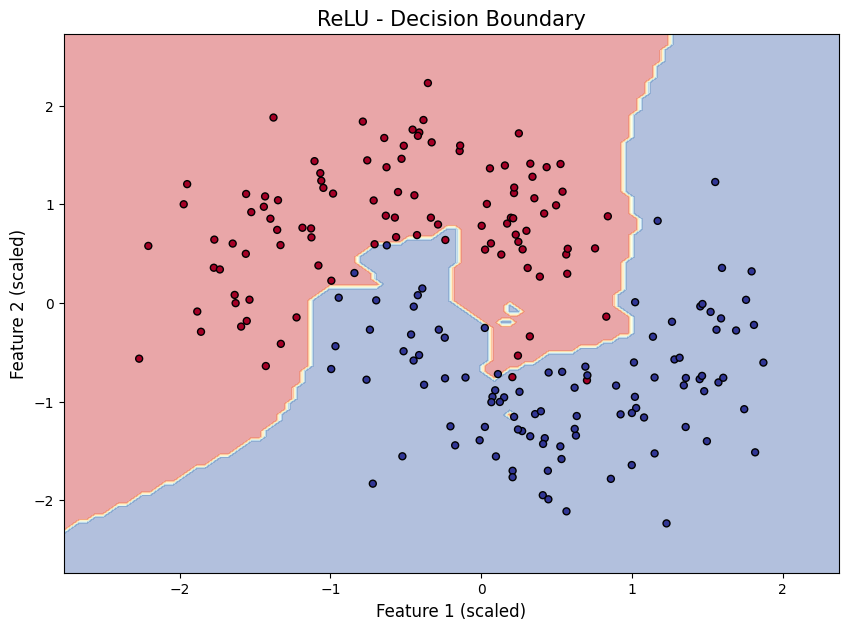

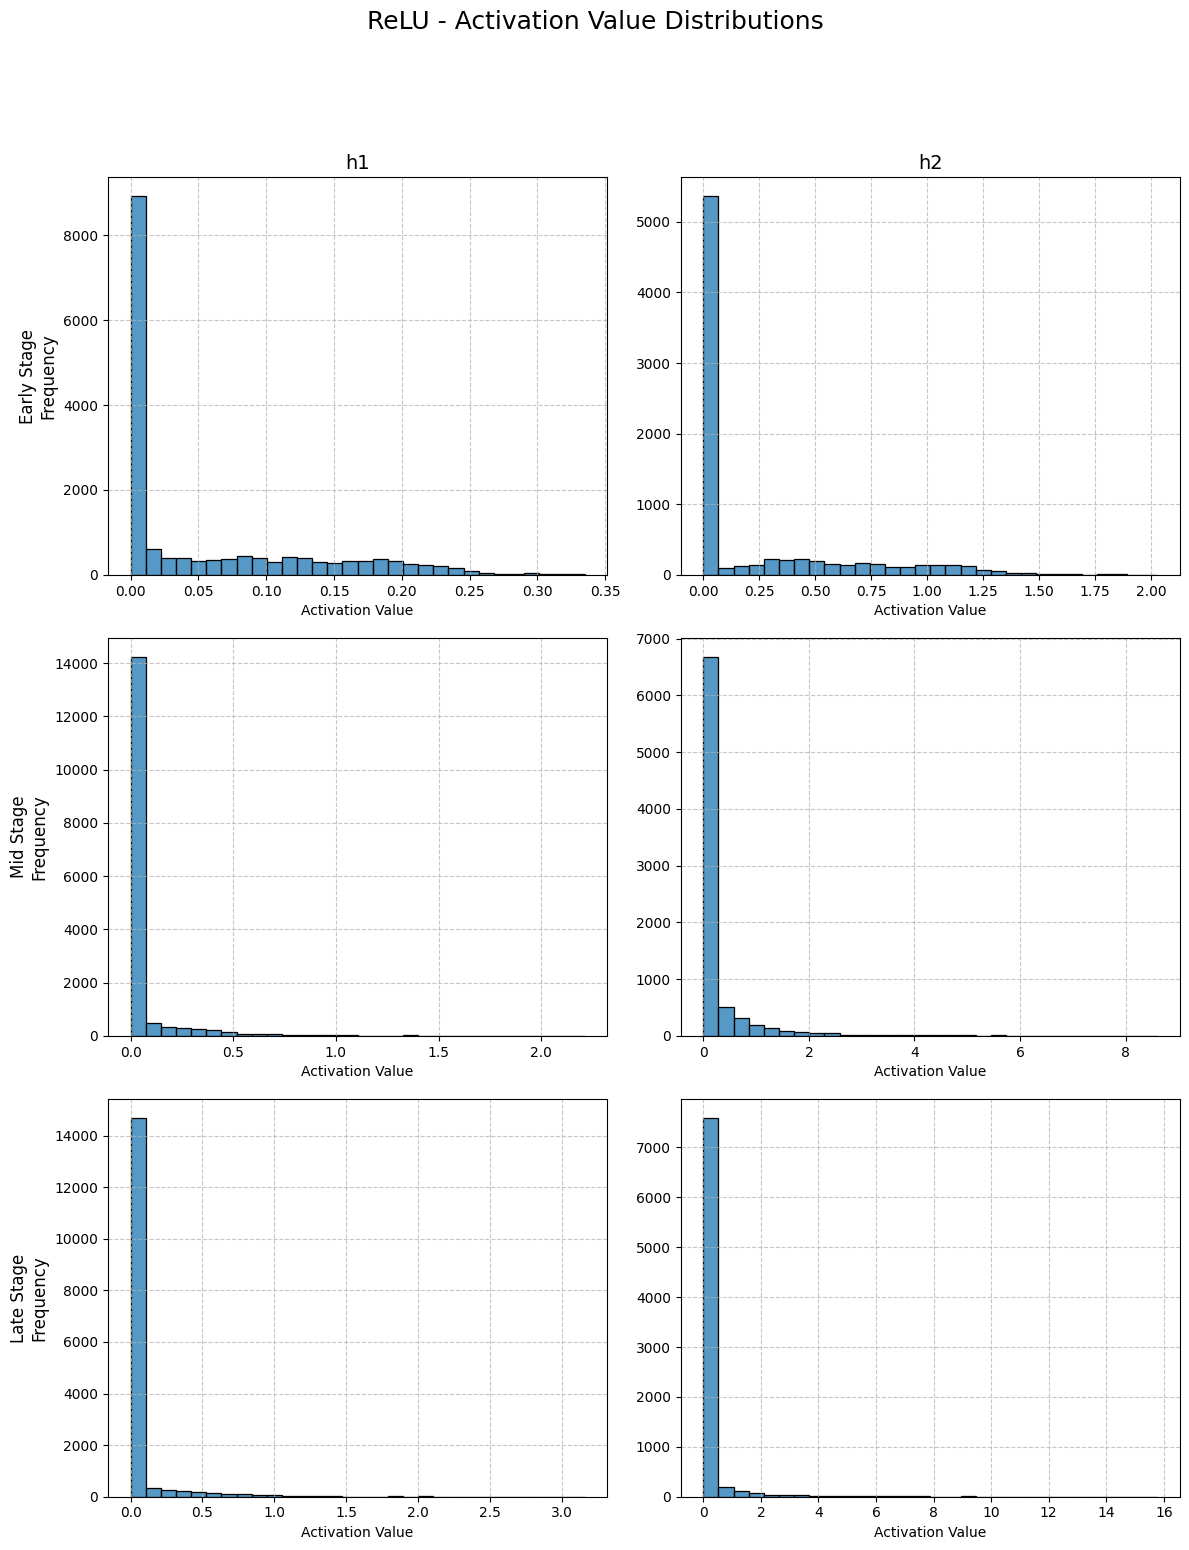

ReLU - Dead Neuron Ratios per layer: {'h1_ReLU': 0.1796875, 'h2_ReLU': 0.40625}
Epoch [30/300], Train Loss: 0.1368, Train Acc: 0.9450, Val Loss: 0.0796, Val Acc: 0.9700
Epoch [60/300], Train Loss: 0.1289, Train Acc: 0.9387, Val Loss: 0.0828, Val Acc: 0.9650
Epoch [90/300], Train Loss: 0.1298, Train Acc: 0.9463, Val Loss: 0.0677, Val Acc: 0.9700
Epoch [120/300], Train Loss: 0.1243, Train Acc: 0.9513, Val Loss: 0.0879, Val Acc: 0.9500
Epoch [150/300], Train Loss: 0.1335, Train Acc: 0.9437, Val Loss: 0.0831, Val Acc: 0.9750
Epoch [180/300], Train Loss: 0.1232, Train Acc: 0.9463, Val Loss: 0.0741, Val Acc: 0.9750
Epoch [210/300], Train Loss: 0.1192, Train Acc: 0.9437, Val Loss: 0.0734, Val Acc: 0.9750
Epoch [240/300], Train Loss: 0.1241, Train Acc: 0.9487, Val Loss: 0.0952, Val Acc: 0.9500
Epoch [270/300], Train Loss: 0.1278, Train Acc: 0.9513, Val Loss: 0.0828, Val Acc: 0.9650
Epoch [300/300], Train Loss: 0.1118, Train Acc: 0.9525, Val Loss: 0.0858, Val Acc: 0.9550


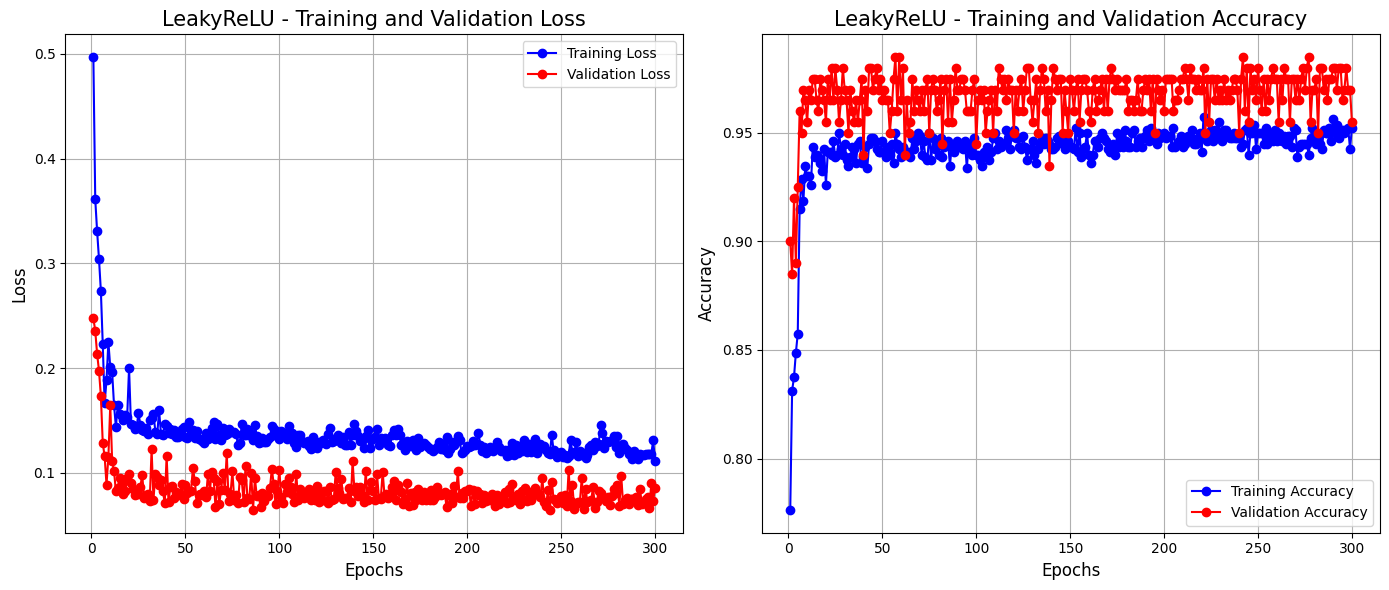

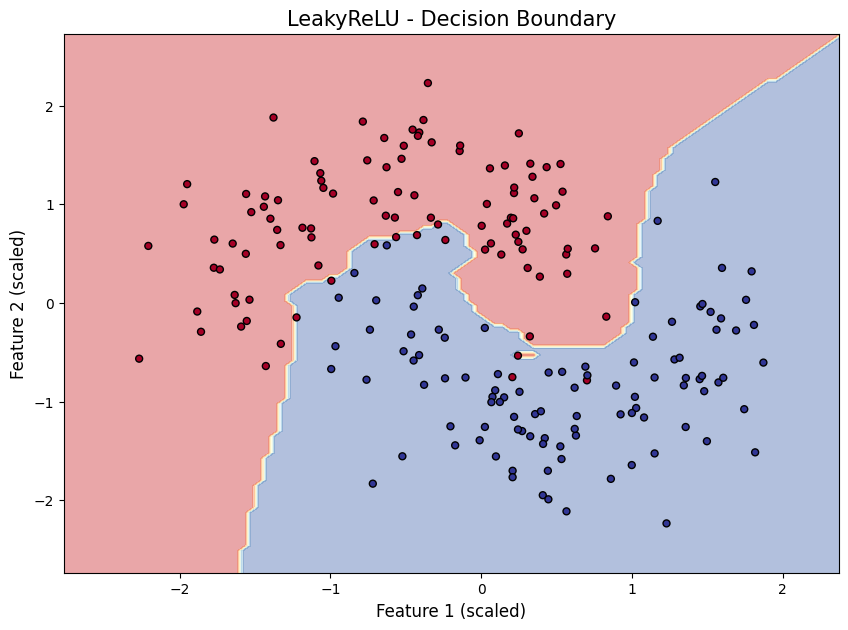

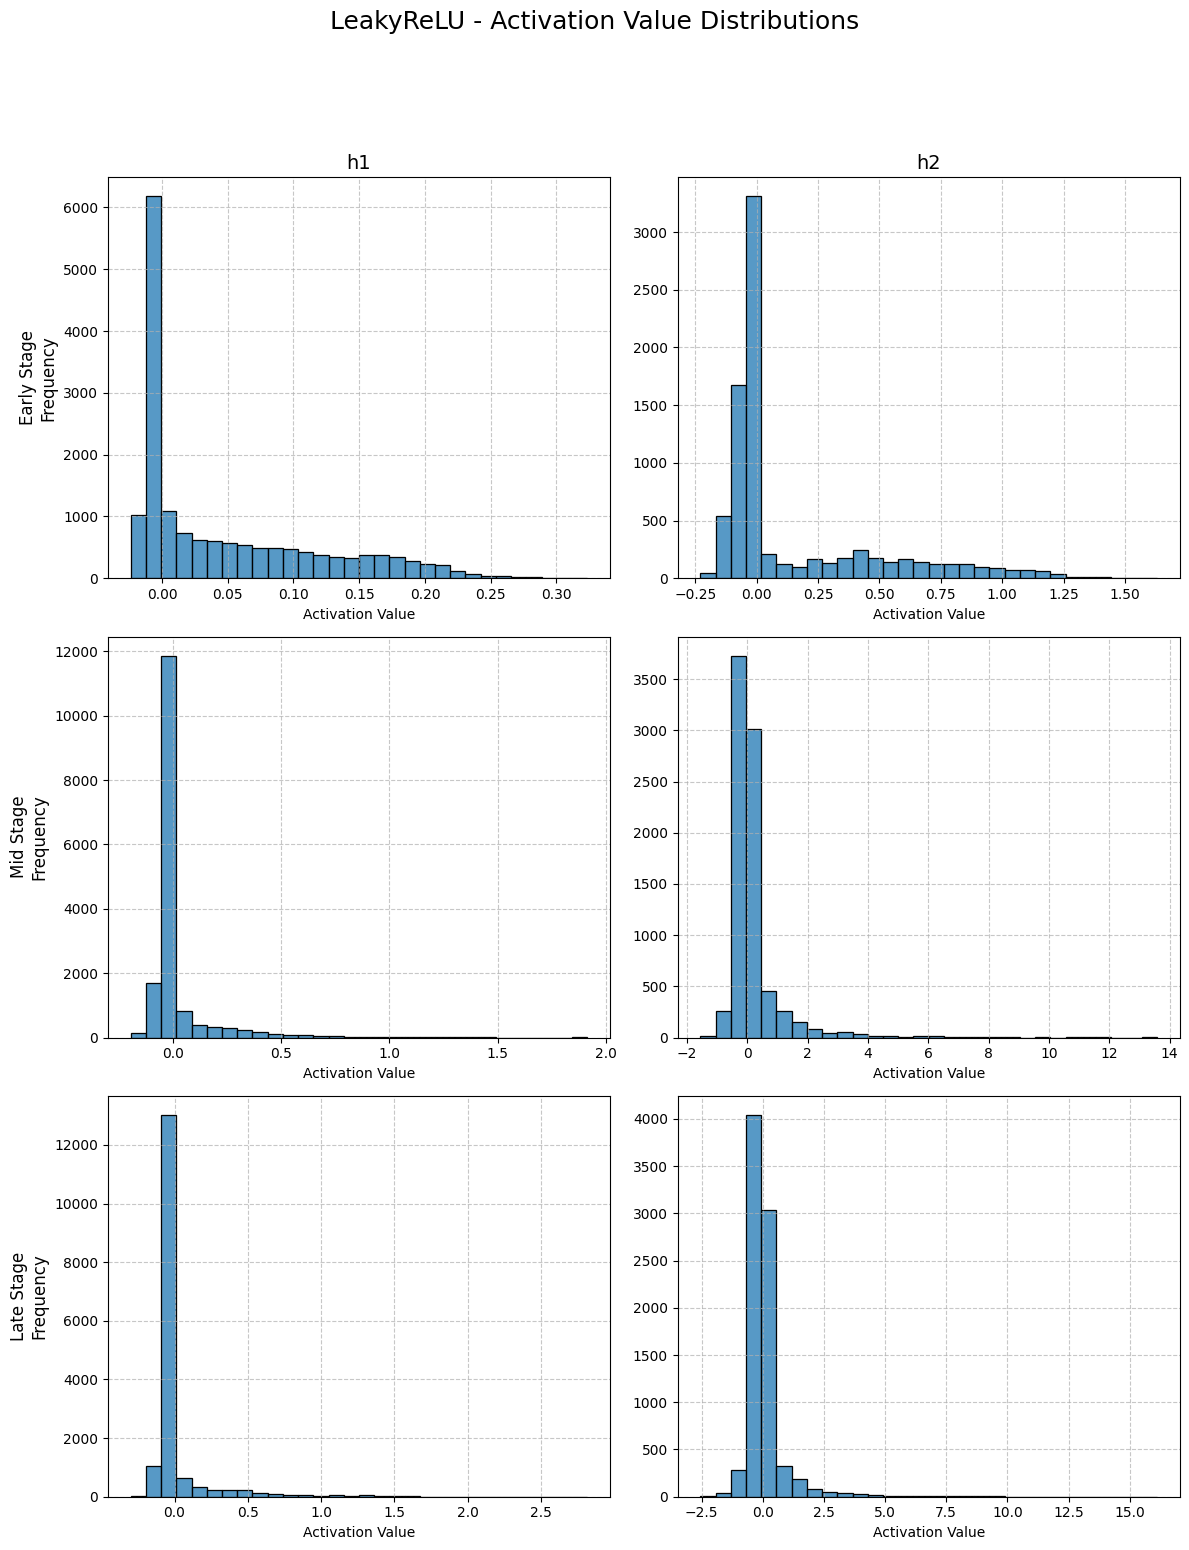

LeakyReLU - Dead Neuron Ratios per layer: {'h1_LeakyReLU': 0.0, 'h2_LeakyReLU': 0.0}
Epoch [30/300], Train Loss: 0.3275, Train Acc: 0.8400, Val Loss: 0.2520, Val Acc: 0.8850
Epoch [60/300], Train Loss: 0.3182, Train Acc: 0.8438, Val Loss: 0.2410, Val Acc: 0.9150
Epoch [90/300], Train Loss: 0.3137, Train Acc: 0.8425, Val Loss: 0.2456, Val Acc: 0.9050
Epoch [120/300], Train Loss: 0.3140, Train Acc: 0.8438, Val Loss: 0.2451, Val Acc: 0.9100
Epoch [150/300], Train Loss: 0.3138, Train Acc: 0.8450, Val Loss: 0.2336, Val Acc: 0.9050
Epoch [180/300], Train Loss: 0.3090, Train Acc: 0.8450, Val Loss: 0.2361, Val Acc: 0.9050
Epoch [210/300], Train Loss: 0.3086, Train Acc: 0.8438, Val Loss: 0.2280, Val Acc: 0.9000
Epoch [240/300], Train Loss: 0.3237, Train Acc: 0.8425, Val Loss: 0.2429, Val Acc: 0.9050
Epoch [270/300], Train Loss: 0.3093, Train Acc: 0.8462, Val Loss: 0.2354, Val Acc: 0.9050
Epoch [300/300], Train Loss: 0.3120, Train Acc: 0.8450, Val Loss: 0.2378, Val Acc: 0.9050


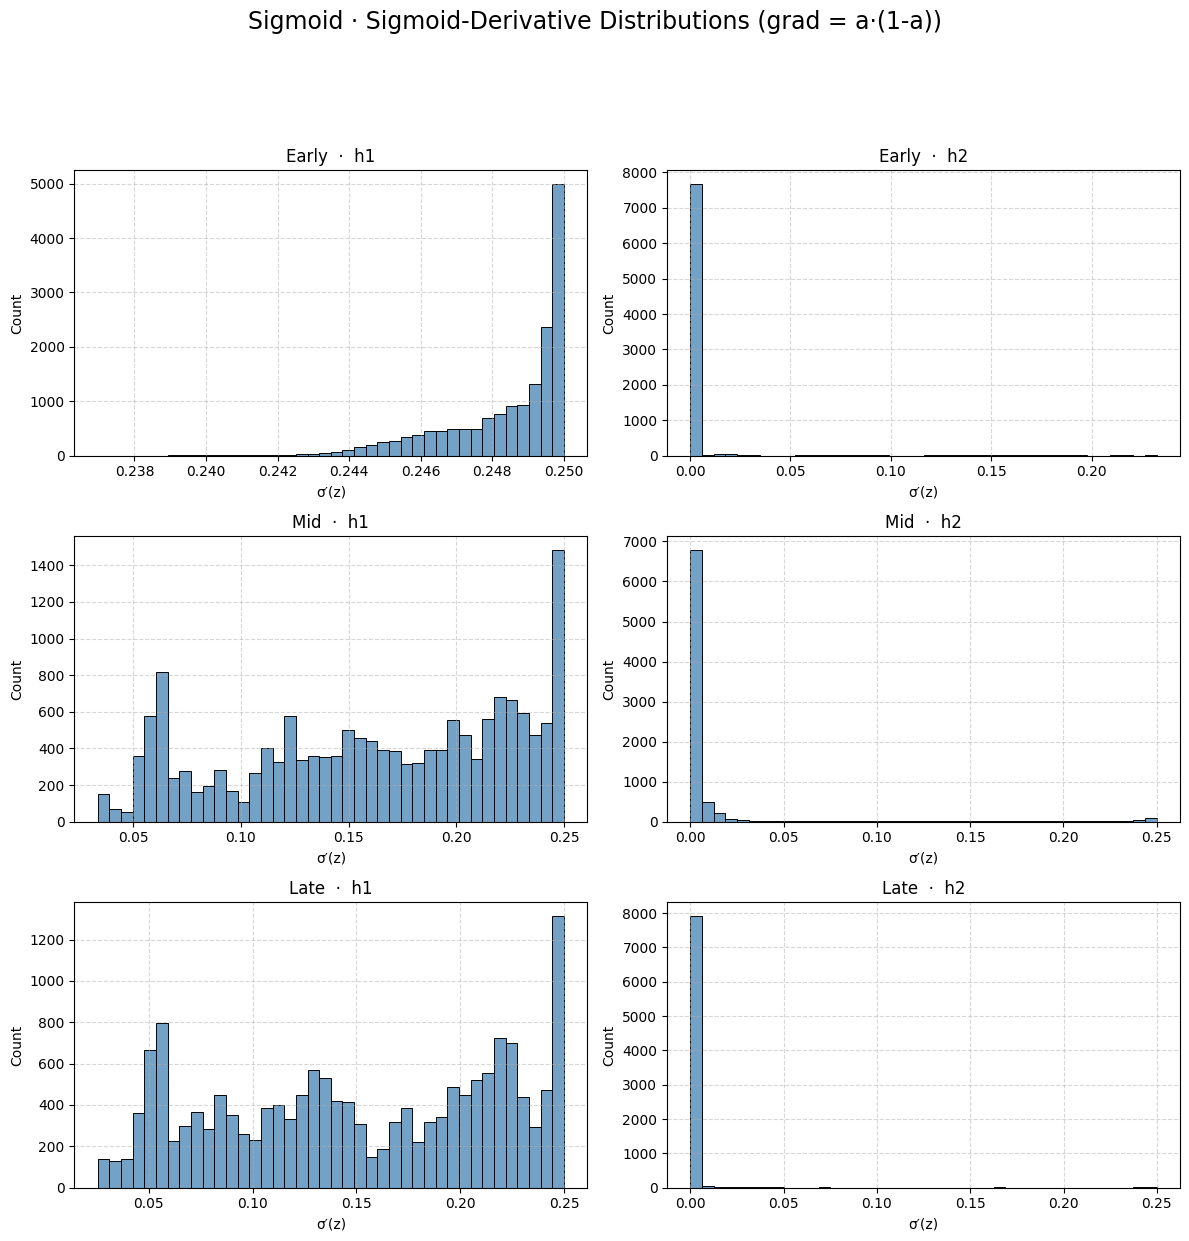


 Vanishing-Gradient 비율 (%)


Stage,early,late,mid
Layer,,,
h1_Sigmoid,0.0,0.0,0.0
h2_Sigmoid,93.8,97.1,87.4


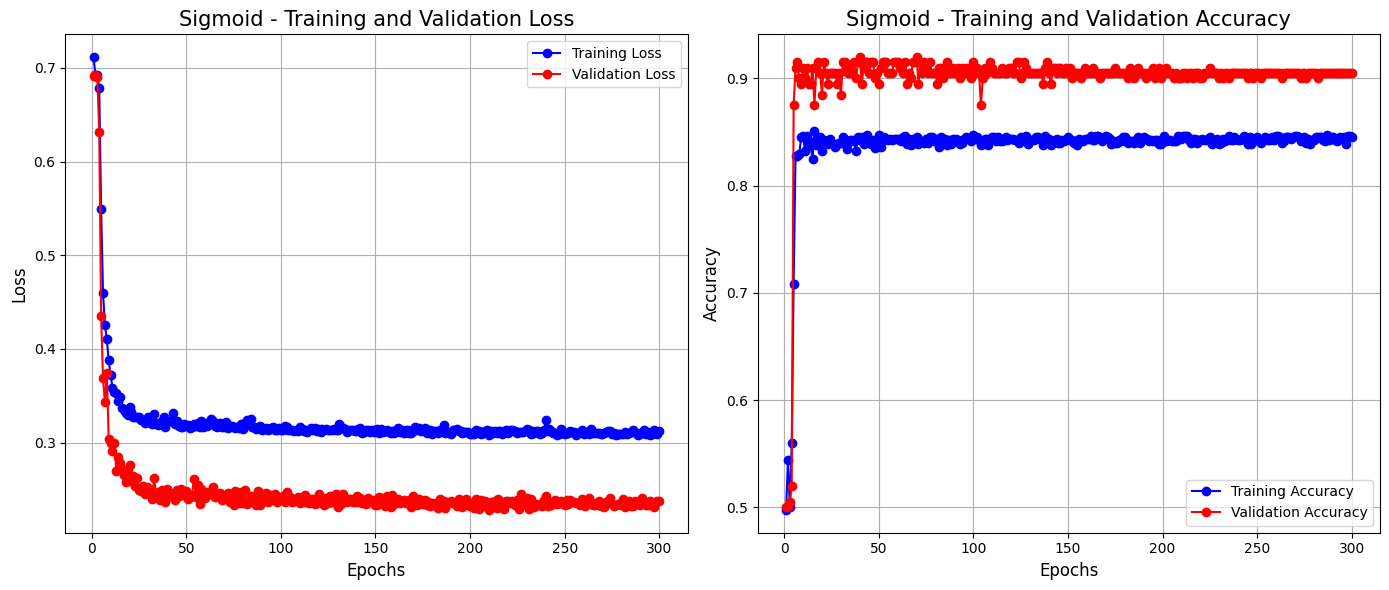

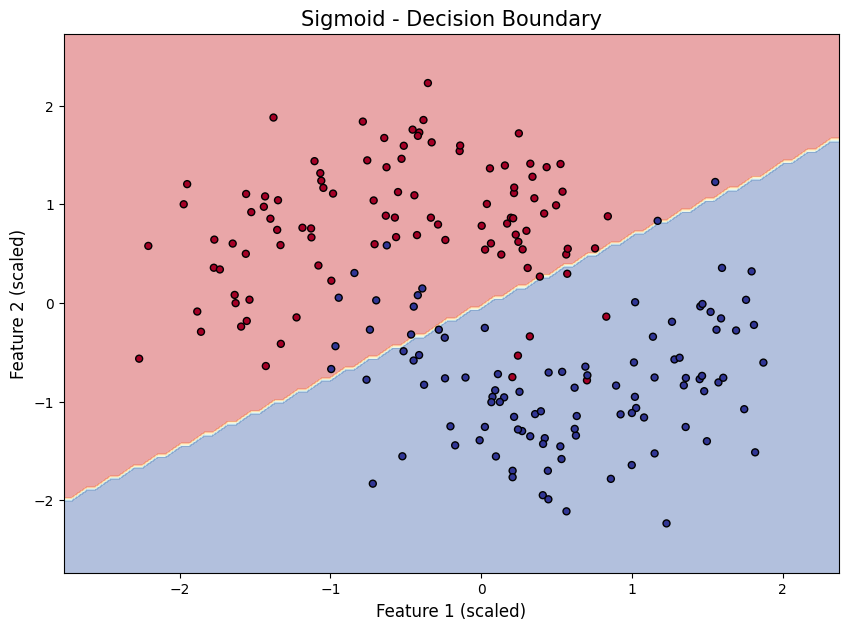

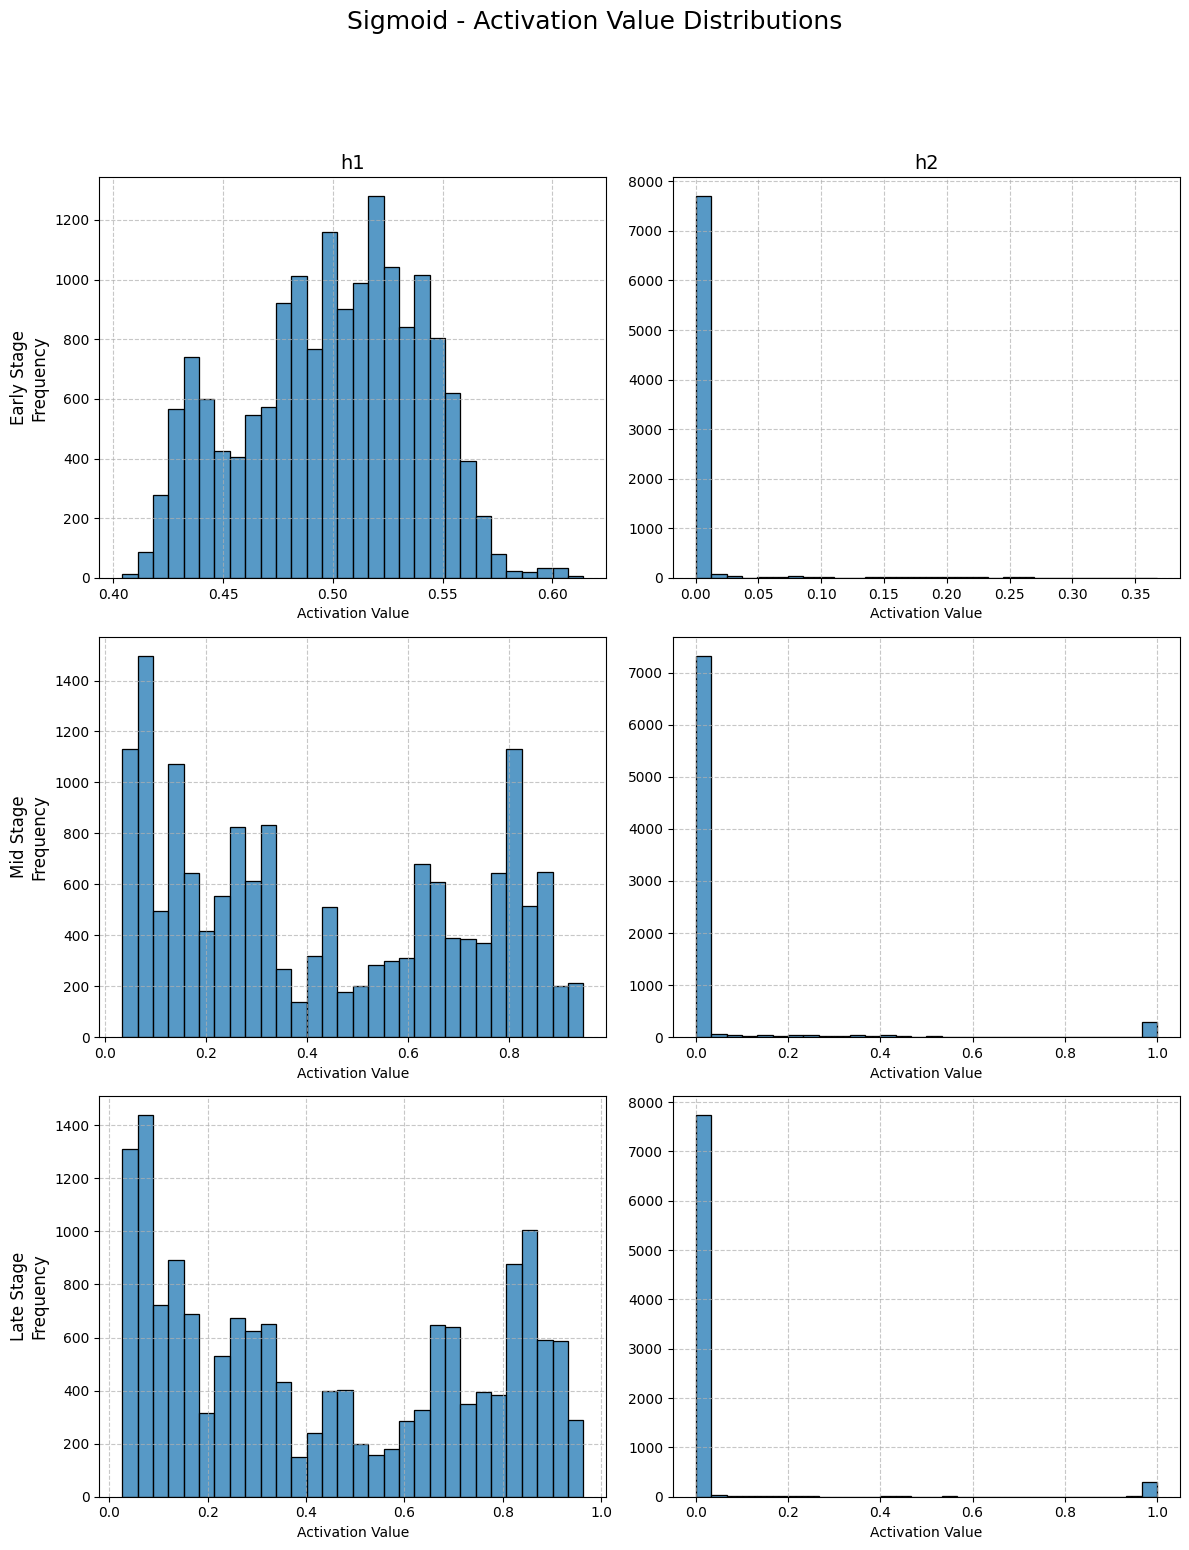

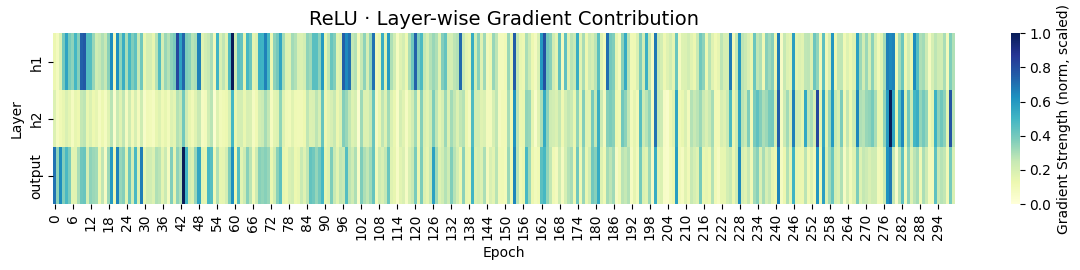

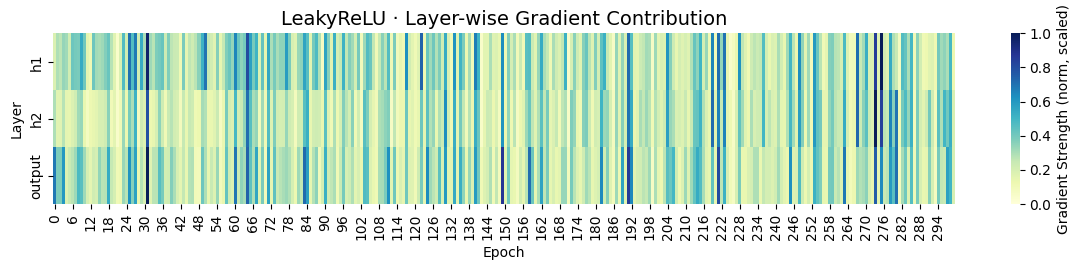

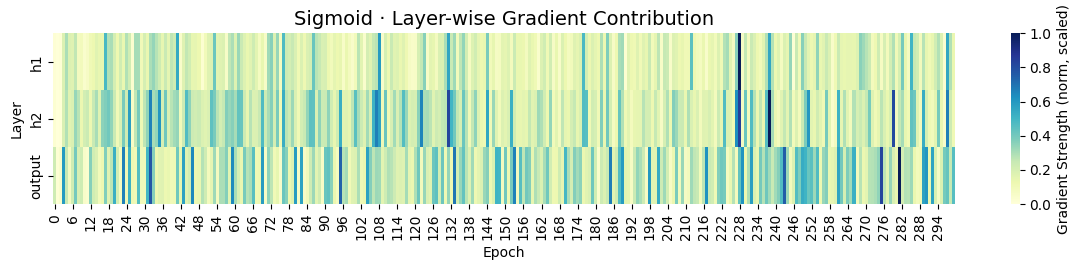

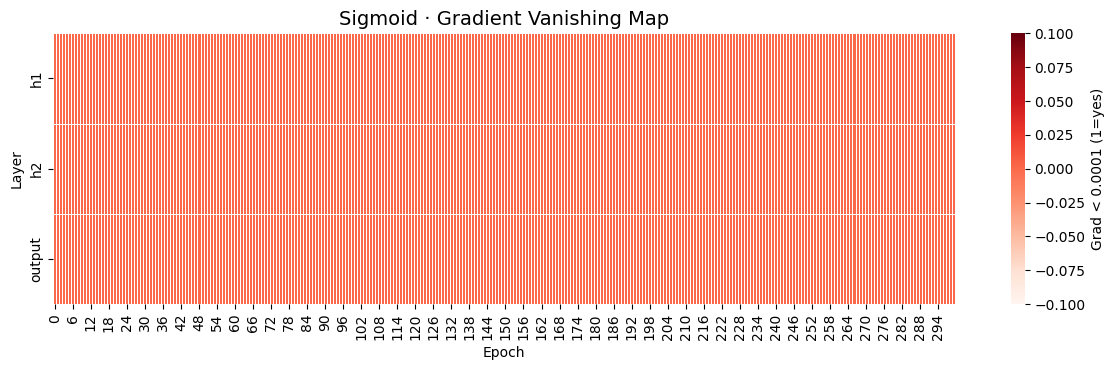

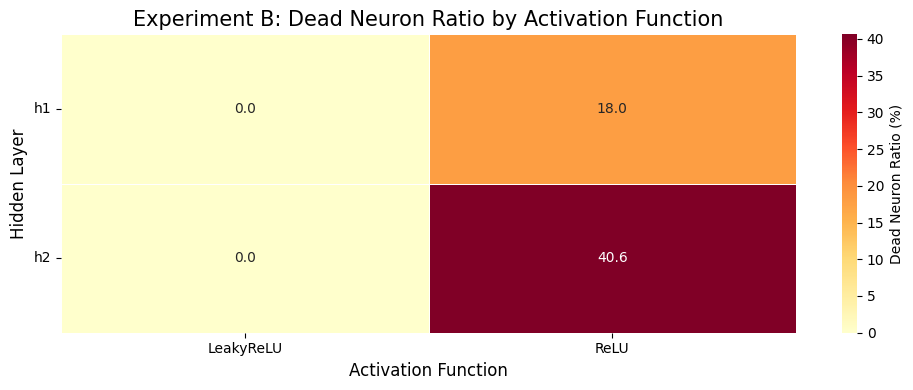

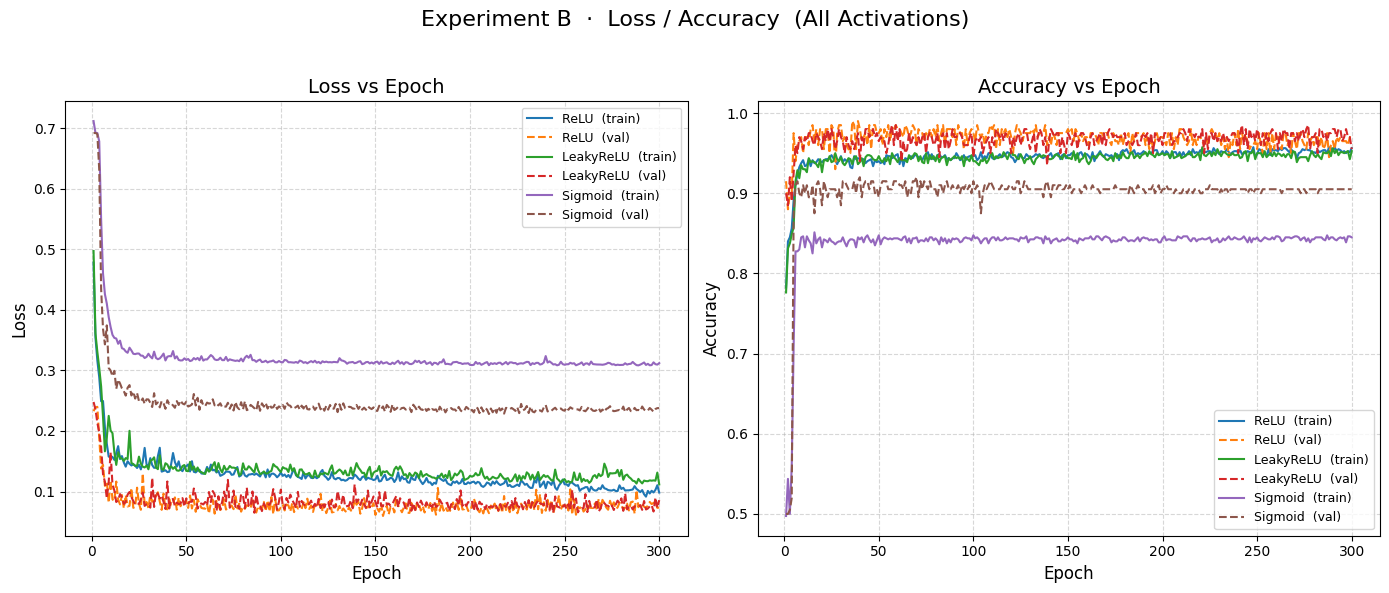



--- 실험 B: 활성화 함수 비교 정량적 결과 요약 ---
   활성화 함수 Dead ReLU 비율 (%) 최종 정확도 (%)  수렴 속도
     ReLU             29.3      97.00      5
LeakyReLU              0.0      95.50      6
  Sigmoid              N/A      90.50    300


In [143]:
# --- Main Experiment B Script ---
def run_experiment_b():
    train_loader, test_loader, X_train_t, y_train_t, X_test_t, y_test_t, scaler = \
        load_and_preprocess_data('make_moons', n_samples=N_SAMPLES_MOONS, noise=NOISE_MOONS)

    activation_functions_to_test = ["ReLU", "LeakyReLU", "Sigmoid"] # 실험할 활성화 함수 리스트

    experiment_b_results = [] # 정량적 결과 저장용 리스트
    all_dead_neuron_ratios_for_heatmap = {} # 모든 활성화 함수에 대한 죽은 뉴런 비율 저장용 딕셔너리
    all_histories = {}
    all_grad_histories   = {}
    criterion = nn.CrossEntropyLoss() # 손실 함수 (공통)

    for act_fn_name in activation_functions_to_test: # 각 활성화 함수에 대해 반복
        # MLP 초기화 시 hidden_sizes 인자 제거
        model_b = MLP(input_size=INPUT_SIZE_MOONS,
                      output_size=NUM_CLASSES_MOONS,
                      activation_name=act_fn_name,
                      init_std=WEIGHT_INIT_STD)
        model_b.to(DEVICE) # 모델을 지정된 장치로 이동

        optimizer_b = optim.Adam(model_b.parameters(), lr=LEARNING_RATE) # 옵티마이저 (Adam 사용)

        # 모델 학습 및 평가, 활성화 값 로깅
        history, epoch_activations, layer_gradient_history = train_evaluate_model(model_b, criterion, optimizer_b,
                                                          train_loader, test_loader,
                                                          EPOCHS_MOONS, DEVICE)
        all_histories[act_fn_name] = history
        if act_fn_name.lower() == "sigmoid":
            plot_sigmoid_vanishing_gradients(epoch_activations,
                                             threshold=0.01,
                                             title_prefix=act_fn_name)
        all_grad_histories[act_fn_name] = layer_gradient_history
        # 시각화 함수 호출
        plot_loss_accuracy(history, title_prefix=f"{act_fn_name} -")
        plot_decision_boundary(model_b, X_test_t, y_test_t, title_prefix=f"{act_fn_name} -", device=DEVICE)
        plot_activation_distributions(epoch_activations, act_fn_name)

        current_dead_neuron_ratios = {} # 현재 활성화 함수에 대한 죽은 뉴런 비율
        avg_dead_relu_percentage_str = "N/A" # 최종 표에 들어갈 평균 Dead ReLU 비율 문자열

        if 'relu' in act_fn_name.lower(): # ReLU 또는 LeakyReLU인 경우에만 계산
            current_dead_neuron_ratios = calculate_dead_neuron_ratio(model_b, train_loader, DEVICE)
            all_dead_neuron_ratios_for_heatmap[act_fn_name] = current_dead_neuron_ratios
            print(f"{act_fn_name} - Dead Neuron Ratios per layer: {current_dead_neuron_ratios}")

            # h1, h2 레이어의 Dead ReLU 비율 평균 계산
            ratios_for_avg = []
            h1_key = f'h1_{act_fn_name}'
            h2_key = f'h2_{act_fn_name}'

            if h1_key in current_dead_neuron_ratios:
                ratios_for_avg.append(current_dead_neuron_ratios[h1_key])
            if h2_key in current_dead_neuron_ratios: # MLP 모델은 2개의 활성화 레이어를 가짐
                ratios_for_avg.append(current_dead_neuron_ratios[h2_key])

            if ratios_for_avg: # 하나 이상의 레이어에서 비율이 계산된 경우
                avg_dead_relu_percentage = np.mean(ratios_for_avg) * 100
                avg_dead_relu_percentage_str = f"{avg_dead_relu_percentage:.1f}"
            else: # 비율을 가져오지 못한 경우 (정상적으론 발생 안 함)
                avg_dead_relu_percentage_str = "0.0"

        CONVERGENCE_THRESHOLD = 0.95
        epochs_to_converge = len(history['val_acc'])   # 기본값 = 미수렴(전체 epoch)
        for idx, acc in enumerate(history['val_acc'], start=1):
            if acc >= CONVERGENCE_THRESHOLD:
                epochs_to_converge = idx
                break

        final_val_accuracy = history['val_acc'][-1] * 100

        experiment_b_results.append({
            "활성화 함수"       : act_fn_name,
            "Dead ReLU 비율 (%)": avg_dead_relu_percentage_str,
            "최종 정확도 (%)"   : f"{final_val_accuracy:.2f}",
            "수렴 속도"         : epochs_to_converge
        })
    for act_name, grad_hist in all_grad_histories.items():
      plot_layer_contribution_heatmap(grad_hist, act_name=act_name)
    vanish_df = grad_vanishing_matrix(layer_gradient_history, threshold=1e-4)
    plot_grad_vanishing_heatmap(vanish_df, act_name=act_fn_name)

    # 죽은 뉴런 히트맵 전체 시각화
    plot_dead_neuron_heatmap(all_dead_neuron_ratios_for_heatmap, title_prefix="Experiment B")
    plot_combined_loss_accuracy(all_histories,
                                title="Experiment B  ·  Loss / Accuracy  (All Activations)")
    # 정량적 결과 요약 테이블 출력 (요청된 컬럼 순서 및 이름으로)
    print("\n\n--- 실험 B: 활성화 함수 비교 정량적 결과 요약 ---")
    # DataFrame 생성 시 컬럼 순서 지정
    df_columns = ["활성화 함수", "Dead ReLU 비율 (%)", "최종 정확도 (%)", "수렴 속도"]
    results_df_b = pd.DataFrame(experiment_b_results, columns=df_columns)
    print(results_df_b.to_string(index=False)) # index=False로 DataFrame 인덱스 미출력


if __name__ == "__main__":
    run_experiment_b() # 실험 B 실행 함수 호출